In [1]:
# Imports to test model
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from transformers import DistilBertForSequenceClassification, AutoTokenizer
from transformers import pipeline

/home/usmiva/anaconda3/envs/iris-task/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model = DistilBertForSequenceClassification.from_pretrained("/home/usmiva/progz/iris-task/datasets/results_multiclass/checkpoint-2280")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

Device set to use cpu


In [6]:
import pandas as pd
test_df = pd.read_csv('/home/usmiva/progz/iris-task/datasets/arxiv_200_multiclass_test.csv')

In [7]:
test_df['predicted'] = test_df['text'].apply(lambda x: classifier(x))

Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The size of tensor a (572) must match the size of tensor b (512) at non-singleton dimension 1

In [18]:
# Let's check which text is breacking the model

for index, row in test_df.iterrows():
    test_df.at[index, 'predicted_out'] = classifier(row['text'])

RuntimeError: The size of tensor a (538) must match the size of tensor b (512) at non-singleton dimension 1

In [21]:
len(test_df['text'][161])

1625

In [22]:
test_df = test_df.drop(161)

In [23]:
test_df['str_len'] = test_df['text'].apply(lambda x: len(x))

In [ ]:
# This is a work-around while finding a way to pad texts to the max token input size of DistilBERT

shorter_test_df = test_df[test_df['str_len'] < 1600]

In [29]:
shorter_test_df.shape, test_df.shape

((342, 4), (378, 4))

In [30]:
shorter_test_df['predicted_out'] = shorter_test_df['text'].apply(lambda x: classifier(x))

/tmp/ipykernel_164141/628207249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shorter_test_df['predicted_out'] = shorter_test_df['text'].apply(lambda x: classifier(x))


In [37]:
shorter_test_df.head()

,text,label,predicted_out,str_len,predicted_id
0,Extension of the composite CBS-QB3 method to s...,1,"[{'label': 'cond-mat', 'score': 0.398153692483...",716,3
1,A Stochastic Automata Network Description for ...,9,"[{'label': 'q-bio', 'score': 0.9487534165382385}]",960,9
2,Embedding of Time-Delayed Quantum Feedback in ...,12,"[{'label': 'quant-ph', 'score': 0.945001661777...",912,12
3,Inverse continuity of the numerical range map ...,2,"[{'label': 'math', 'score': 0.9461358785629272}]",561,2
4,Renormalized Holographic Subregion Complexity ...,6,"[{'label': 'hep-th', 'score': 0.89212894439697...",1325,6


In [35]:
label2id = model.config.label2id

In [47]:
label2id

{'astro-ph': 5,
 'cond-mat': 3,
 'cs': 10,
 'econ': 18,
 'eess': 17,
 'gr-qc': 4,
 'hep-ex': 7,
 'hep-lat': 14,
 'hep-ph': 0,
 'hep-th': 6,
 'math': 2,
 'nlin': 8,
 'nucl-ex': 13,
 'nucl-th': 11,
 'physics': 1,
 'q-bio': 9,
 'q-fin': 16,
 'quant-ph': 12,
 'stat': 15}

In [36]:
shorter_test_df['predicted_id'] = shorter_test_df['predicted_out'].apply(lambda x: label2id[x[0]['label']])

/tmp/ipykernel_164141/2348276535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shorter_test_df['predicted_id'] = shorter_test_df['predicted_out'].apply(lambda x: label2id[x[0]['label']])


In [38]:
y_true = list(shorter_test_df['label'])
y_pred = list(shorter_test_df['predicted_id'])
accuracy_score(y_true, y_pred)

0.7953216374269005

In [43]:
print(classification_report(y_true, y_pred, labels=list(label2id.values())))

              precision    recall  f1-score   support

           5       0.88      1.00      0.93        14
           3       0.68      0.94      0.79        16
          10       0.79      0.73      0.76        15
          18       0.75      0.71      0.73        17
          17       0.77      0.94      0.85        18
           4       0.95      0.82      0.88        22
           7       0.90      1.00      0.95        19
          14       0.81      1.00      0.90        13
           0       0.67      0.73      0.70        11
           6       0.93      0.65      0.76        20
           2       0.83      0.87      0.85        23
           8       0.60      0.60      0.60        10
          13       0.67      0.53      0.59        15
          11       0.83      0.80      0.82        25
           1       0.50      0.29      0.37        17
           9       0.85      0.89      0.87        19
          16       0.86      0.90      0.88        21
          12       0.80    

In [44]:
cm = confusion_matrix(y_true, y_pred)


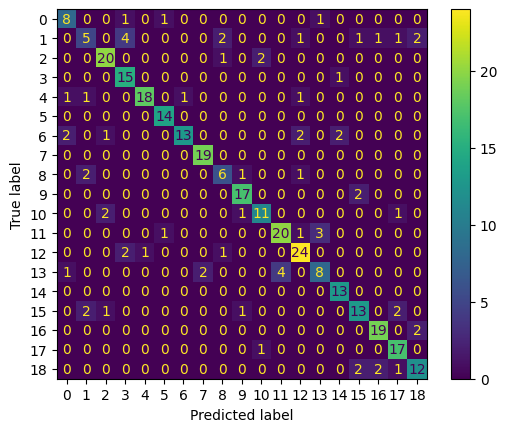

<Figure size 2400x2200 with 0 Axes>

In [50]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.figure(figsize=(24,22))
#plt.legend(label2id)
plt.show()

In [ ]:
"""From these results can be seen that there is one class that is wrongly classified most of the time. 
The problematic label has id 1 and is maped to the physics class. 
It is predicted 4 times as 3 which maps to cond-mat class or "Conditional matter" - a subcategory of physics as we can see in the taxonomy here https://arxiv.org/category_taxonomy
This is probably due to the fact that these two classes are very similar in content.
Other misclassifications of Physics (id 1) are are not as frequent as these 4 misclassifications to Cond-mat (id 3).
The other classes are classified with very high precision and recall with some room for improvements.
TODO:

1. Experiment with the taxonomyby merging or adding classes. Model on the sub classes. From what is seen 'nucl-ex' with ID 13 and'nucl-th' with ID 11 are mistaken with each other and thus can be merged into one class 'nuclear physics'.
2. More data can be used for the training as well.
3. Hyperparameter tuning.
4. Test different BERT models like SciBERT by Beltagy et. al. - https://aclanthology.org/D19-1371.pdf.

"""
